# mean Functional & Structural connectivity strength correlates of mean qMRI gradients

### Libraries

In [1]:
import os
import numpy as np
import nibabel as nb
import pandas as pd
import glob
import matplotlib.pyplot as plt
from nilearn import plotting
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.mesh.array_operations import smooth_array
from brainspace.datasets import load_mask
from brainspace.utils.parcellation import map_to_labels
from brainspace.datasets import load_parcellation
from brainspace.null_models import SpinPermutations
from brainstat.datasets import fetch_mask
from brainstat.stats.terms import FixedEffect
from brainstat.stats.SLM import SLM
import scipy.stats as stats
from scipy import stats
import scipy as sp
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.stats import rankdata
from scipy.linalg import eigh
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import copy
import cmocean
import statsmodels.api as sm
import pandas as pd
from sklearn.linear_model import LinearRegression
from igraph import Graph
from neuromaps.datasets import fetch_fslr
from surfplot import Plot

### Load surfaces and masks

In [2]:
# Set dataset PNI as working directory
os.chdir('/data_/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0')

# Path to MICAPIPE surf = mask_5k !
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

# Load native mid surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_5k = np.concatenate((mask_lh, mask_rh), axis=0)

# Boolean mask
mask_surf = mask_5k != 0

f5k_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.surf.gii', itype='gii')
f5k_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.surf.gii', itype='gii')

### Load intensity profiles

In [3]:
T1map_swm_int = np.load('/host/verges/tank/data/youngeun/myjupyter/array/PNC-10sub_T1map_swmIP.npy') # T1 map SWM intensity profiles
MTSAT_swm_int = np.load('/host/verges/tank/data/youngeun/myjupyter/array/PNC-10sub_MTsat_swmIP.npy') # MTsat SWM intensity profiles

### Functions

## F1: MPC calculation

In [4]:
# Function to build the MPC from an intencity profile
def build_mpc(data, mask):
    # If no parcellation is provided, MPC will be computed vertexwise
    I = data

    # Calculate mean across columns, excluding mask and any excluded labels input
    I_M = np.nanmean(np.float32(np.where(mask, I, np.nan)), axis=1)

    # Get residuals of all columns (controlling for mean)
    I_resid = np.zeros(I.shape)
    for c in range(I.shape[1]):
        y = I[:,c]
        x = I_M
        slope, intercept, _, _, _ = sp.stats.linregress(x,y)
        y_pred = intercept + slope*x
        I_resid[:,c] = y - y_pred

    # Calculate correlation coefficient of the intesities with residuals
    R = np.corrcoef(I_resid, rowvar=False)

    # Log transform
    MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
    MPC[np.isnan(MPC)] = 0
    MPC[np.isinf(MPC)] = 0

    # CLEANUP: correct diagonal and round values to reduce file size
    # Replace all values in diagonal by zeros to account for floating point error
    for i in range(0,MPC.shape[0]):
            MPC[i,i] = 0
    
    # Output MPC, microstructural profiles, and problem nodes
    return (MPC)

# Create the gradients from the MPC matrix
def mpc_dm(MPC, mpc_mask, Ngrad=3, kernel=None, sparsity=0.9):
    # Cleanup before diffusion embeding
    MPC[~np.isfinite(MPC)] = 0
    MPC[np.isnan(MPC)] = 0
    MPC[MPC==0] = np.finfo(float).eps

    # Get the index of the non medial wall regions
    indx = np.where(mpc_mask==1)[0]

    # Slice the matrix
    MPC_masked = MPC[indx, :]
    MPC_masked = MPC_masked[:, indx]
    MPC_masked.shape

    # Calculate the gradients
    MPCgm = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel=kernel)
    MPCgm.fit(MPC_masked, sparsity=sparsity)
    
    # Map gradients to surface
    grad = [None] * Ngrad
    for i, g in enumerate(MPCgm.gradients_.T[0:Ngrad,:]):
        # create a new array filled with NaN values
        g_nan = np.full(mask_surf.shape, np.nan)
        g_nan[indx] = g

        # fill in the calculated values into the corresponding indices of the new array
        grad[i] = g_nan
    
    return (MPCgm, grad)

def _build_kernel(x, kernel, gamma=None):

    if kernel in {'pearson', 'spearman'}:
        if kernel == 'spearman':
            x = np.apply_along_axis(rankdata, 1, x)
        return np.corrcoef(x)

    if kernel in {'cosine', 'normalized_angle'}:
        x = 1 - squareform(pdist(x, metric='cosine'))
        if kernel == 'normalized_angle':
            x = 1 - np.arccos(x, x)/np.pi
        return x

    if kernel == 'gaussian':
        if gamma is None:
            gamma = 1 / x.shape[1]
        return rbf_kernel(x, gamma=gamma)

    if callable(kernel):
        return kernel(x)

    raise ValueError("Unknown kernel '{0}'.".format(kernel))

def compute_affinity(x, kernel=None, sparsity=.9, pre_sparsify=True,
                     non_negative=True, gamma=None):
    """Compute affinity matrix.

    Parameters
    ----------
    x : ndarray, shape = (n_samples, n_feat)
        Input matrix.
    kernel : str, None or callable, optional
        Kernel function. If None, only sparsify. Default is None.
        Valid options:

        - If 'pearson', use Pearson's correlation coefficient.
        - If 'spearman', use Spearman's rank correlation coefficient.
        - If 'cosine', use cosine similarity.
        - If 'normalized_angle': use normalized angle between two vectors. This
          option is based on cosine similarity but provides similarities
          bounded between 0 and 1.
        - If 'gaussian', use Gaussian kernel or RBF.

    sparsity : float or None, optional
        Proportion of smallest elements to zero-out for each row.
        If None, do not sparsify. Default is 0.9.
    pre_sparsify : bool, optional
        Sparsify prior to building the affinity. If False, sparsify the final
        affinity matrix.
    non_negative : bool, optional
        If True, zero-out negative values. Otherwise, do nothing.
    gamma : float or None, optional
        Inverse kernel width. Only used if ``kernel == 'gaussian'``.
        If None, ``gamma = 1./n_feat``. Default is None.

    Returns
    -------
    affinity : ndarray, shape = (n_samples, n_samples)
        Affinity matrix.
    """

    # Do not accept sparse matrices for now
    if sp.issparse(x):
        x = x.toarray()

    if not pre_sparsify and kernel is not None:
        x = _build_kernel(x, kernel, gamma=gamma)

    if sparsity is not None and sparsity > 0:
        x = dominant_set(x, k=1-sparsity, is_thresh=False, as_sparse=False)

    if pre_sparsify and kernel is not None:
        x = _build_kernel(x, kernel, gamma=gamma)

    if non_negative:
        x[x < 0] = 0

    return x

## F2: Spin permutations: Brain connectivity strength ~ SWM feature G1

In [5]:
# Shape of the fsLR-5k matrices
N5k = 9684

# Load spheres fsLR5k
sphere_lh = read_surface(micapipe+'/surfaces/fsLR-5k.L.sphere.surf.gii', itype='gii')
sphere_rh = read_surface(micapipe+'/surfaces/fsLR-5k.R.sphere.surf.gii', itype='gii')

# Let's create some rotations
n_rand = 1000

spinp = SpinPermutations(n_rep=n_rand, random_state=0)
spinp.fit(sphere_lh, points_rh=sphere_rh)

SpinPermutations(n_rep=1000, random_state=0)

In [6]:
def plot_ctx_spin_permutation(ctx, qMRI):
    """
    Plots structural-spin permutation results with functional connectivity and qMRI data.
    
    Parameters:
    ctx : array-like
        Functional connectivity data.
    qMRI : array-like
        qMRI intensity profile data.
    """
    # Copy input data to avoid modifying the original
    if ctx == 'functional':
        fdata_10sub = copy.deepcopy(fc_ctx)
    elif ctx == 'structural':
        fdata_10sub = copy.deepcopy(S_log)
    if qMRI == 'T1map':
        swm_data = copy.deepcopy(T1map_swm_int)
    elif qMRI == 'MTSAT':
        swm_data = copy.deepcopy(MTSAT_swm_int)
    
    # Split left and right hemisphere data
    N5k = len(fdata_10sub)
    fdata_L, fdata_R = fdata_10sub[:N5k//2], fdata_10sub[N5k//2:]
    
    # Compute mMPC and gradients
    MPC = build_mpc(swm_data, mask_surf)  # Assuming mask_surf is predefined
    _, grad_MPC = mpc_dm(MPC, mask_surf, Ngrad=3, kernel=None, sparsity=0.95)
    target_MPC = grad_MPC[0]
    
    # Spin permutation on full data
    func_rotated = np.hstack(spinp.randomize(fdata_L, fdata_R))
    func_rotated_clean = np.nan_to_num(func_rotated)
    
    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Define valid data mask
    mask = ~np.isnan(fdata_10sub) & ~np.isnan(target_MPC)
    valid_mask = mask & ~((fdata_10sub == 0) & (target_MPC == 0))
    valid_fc, valid_grad = fdata_10sub[valid_mask], target_MPC[valid_mask]
    
    # Compute observed correlation
    r_obs, _ = spearmanr(valid_fc, valid_grad)
    
    # Compute permutation-based correlations
    r_spin = np.array([spearmanr(perm[valid_mask], valid_grad)[0] for perm in func_rotated_clean])
    p_spin = np.mean(np.abs(r_spin) >= np.abs(r_obs))
    
    # Density Plot with Contour
    sns.kdeplot(x=valid_fc, y=valid_grad, fill=True, levels=10, cmap="Greys", ax=axs[0])
    sns.kdeplot(x=valid_fc, y=valid_grad, levels=10, color='black', linewidths=1, ax=axs[0])
    
    # Nonlinear correlation line (LOWESS)
    lowess = sm.nonparametric.lowess(valid_grad, valid_fc, frac=0.3)
    axs[0].plot(lowess[:, 0], lowess[:, 1], color='red', linestyle='--', linewidth=2)

    if ctx == 'functional':
        axs[0].set_xlabel('Functional Connectivity Strength', fontsize=20)
    elif ctx == 'structural':
        axs[0].set_xlabel('Structural Connectivity Strength', fontsize=20)
    if qMRI == 'T1map':
        axs[0].set_ylabel(r"${\text{G1}}$$_{\text{T1map}}$", fontsize=20)
    elif qMRI == 'MTSAT':
        axs[0].set_ylabel(r"${\text{G1}}$$_{\text{MTsat}}$", fontsize=20)
    axs[0].tick_params(axis='both', which='major', labelsize=16)
    axs[0].grid(False)
    
    # Null Distribution Plot
    axs[1].hist(r_spin, bins=25, density=True, alpha=0.5, color=(.6, .6, .6))
    axs[1].axvline(r_obs, lw=2, ls='--', color='k')
    axs[1].set_xlabel('Correlation Coefficient (r)', fontsize=20)
    axs[1].set_ylabel('Density', fontsize=20)
    axs[1].tick_params(axis='both', which='major', labelsize=16)
    axs[1].grid(False)
    
    # Add text annotation
    textstr = f"r = {r_obs:.3f}, $P_{{spin}}$ = {p_spin:.3f}"
    axs[1].text(0.95, 0.95, textstr, transform=axs[1].transAxes, fontsize=20,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white'))
    
    # Adjust plot aesthetics
    for ax in axs:
        for spine in ax.spines.values():
            spine.set_color('black')
            spine.set_linewidth(1)
    
    fig.tight_layout()
    plt.show()

## Functional Connectome

### Load cortico-cortical functional connectivity data

In [7]:
# Load CSV file containing subject and session information
csv_dir = '/host/percy/local_raid/youngeun/from_mica1/lists'
csv_file = f"10PNC_T1map.csv"
subject_session_info = pd.read_csv(csv_dir + '/' + csv_file, header=None, names=['info'], delimiter=',')

# Extract subject and session information from each row
files = []
for index, row in subject_session_info.iterrows():
    info = row['info'].split(',')
    subject = index[4:]  # Extract subject ID
    session = info[0][4:].strip()  # Extract session ID
    files_fc = f"sub-{subject}/ses-03/func/desc-me_task-rest_bold/surf/*_surf-fsLR-5k_desc-FC.shape.gii"
    files.extend(glob.glob(files_fc))

# Load intensity profiles from each file
profiles = []
for file_path in files:
    profile_data = nb.load(file_path).darrays[0].data
    
    # Fisher transform
    FCz = np.arctanh(profile_data)
    
    # replace inf with 0
    FCz[~np.isfinite(FCz)] = 0
    
    profiles.append(FCz)
profiles = np.array(profiles)
fc = np.mean(profiles, axis=0)
fc_sym = np.triu(fc,1)+fc.T

/tmp/ipykernel_74351/1656040227.py:21: RuntimeWarning: divide by zero encountered in arctanh
  FCz = np.arctanh(profile_data)


In [8]:
# Consider the absolute value
fc_abs = np.abs(fc_sym)
# Compute weighted degree centrality measures from the connectivity data
fc_ctx = np.sum(fc_abs, axis=0)

### Degree centrality (*strength*) of $FC_{abs}$ 

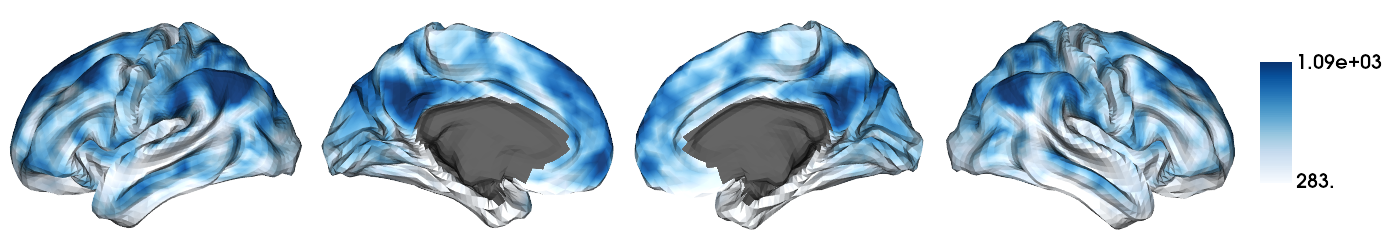

In [9]:
# Compute weighted degree centrality measures from the connectivity data
fc_ctx = np.sum(fc_abs, axis=0)

# Mask the midwall 
fc_ctx[mask_5k == False] = np.nan

# Calculate an optima range of color for visualization
crange=(np.quantile(fc_ctx[mask_5k != False], 0.075), np.quantile(fc_ctx[mask_5k != False], 0.98))

# plot the column mean of the mean connectome surface
plot_hemispheres(f5k_lh, f5k_rh, fc_ctx, cmap='Blues', nan_color=(0.3, 0.3, 0.3, 1),
                      zoom=1.5, size=(1400, 250), embed_nb=True, color_range=crange,
                      color_bar='right', cb__labelTextProperty={"fontSize": 20})

### Functional connectivity strength ~ T1 map G1

/tmp/ipykernel_74351/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/host/verges/tank/data/youngeun/venv_new/lib/python3.10/site-packages/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')


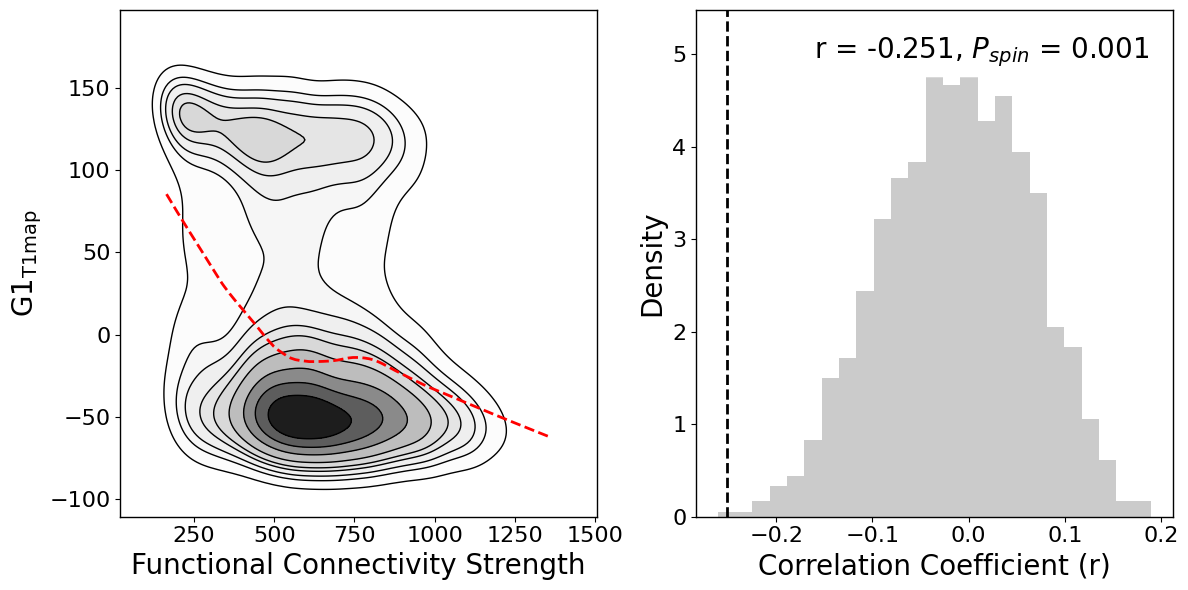

In [10]:
plot_ctx_spin_permutation(ctx='functional', qMRI='T1map')

### Functional connectivity strength ~ MTsat G1

/tmp/ipykernel_74351/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/host/verges/tank/data/youngeun/venv_new/lib/python3.10/site-packages/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')


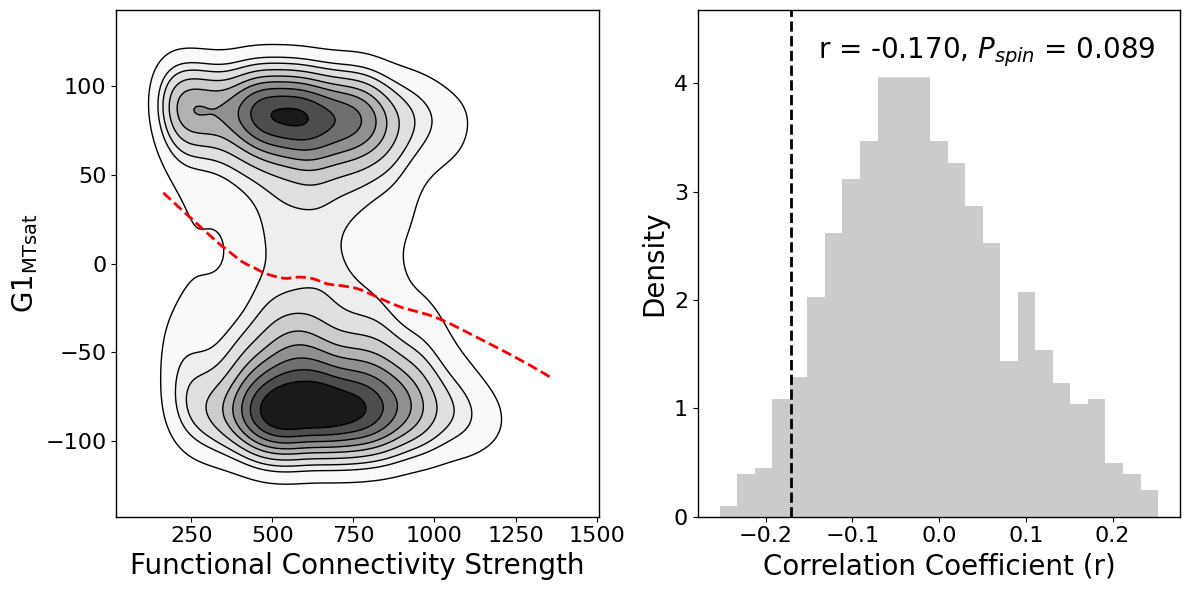

In [11]:
plot_ctx_spin_permutation(ctx='functional', qMRI='MTSAT')

## Structural Connectome

### Load cortico-cortical structural connectivity data

In [12]:
# Load CSV file containing subject and session information
csv_dir = '/host/percy/local_raid/youngeun/from_mica1/lists'
csv_file = f"10PNC_T1map.csv"
subject_session_info = pd.read_csv(csv_dir + '/' + csv_file, header=None, names=['info'], delimiter=',')

# Extract subject and session information from each row
files = []
for index, row in subject_session_info.iterrows():
    info = row['info'].split(',')
    subject = index[4:]  # Extract subject ID
    session = info[0][4:].strip()  # Extract session ID
    files_sc = f"sub-{subject}/ses-01/dwi/connectomes/*_surf-fsLR-5k_desc-iFOD2-40M-SIFT2_full-connectome.shape.gii"
    files.extend(glob.glob(files_sc))

# Load intensity profiles from each file
profiles = []
for file_path in files:
    profile_data = nb.load(file_path).darrays[0].data
    profiles.append(profile_data)
profiles = np.array(profiles)

# Mean structural connectome (lower triangle)
sc = np.mean(profiles, axis=0)

# Generate symmetric matrix
sc_sym = np.triu(sc,1)+sc.T

### Degree centrality ($strength_{log}$) of SC 

/tmp/ipykernel_74351/3789272057.py:11: RuntimeWarning: divide by zero encountered in log
  S_log = np.log(S)


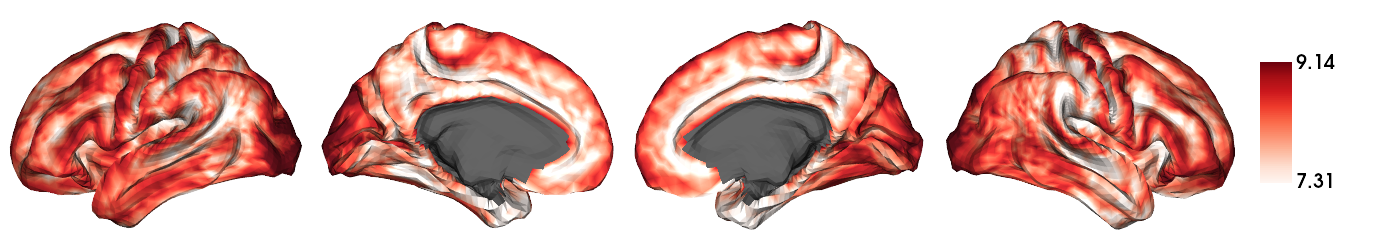

In [13]:
# Log transform the SC to improve visualization
sc_log = np.log(sc_sym+1)

# Calculate the Sum (strength) of the log transformed SC
sc_ctx = np.sum(sc_log, axis=0)

# Calculate the strength (S) from the SC
S = np.sum(sc_sym, axis=0)

# Log the S to normalize the values
S_log = np.log(S)

# Mask the midwall 
S_log[mask_5k == False] = np.nan

# plot the column mean of the mean connectome surface
crange=(np.quantile(S_log[mask_5k != False], 0.1), np.quantile(S_log[mask_5k != False], 0.975))

plot_hemispheres(f5k_lh, f5k_rh, S_log, cmap='Reds', nan_color=(0.3, 0.3, 0.3, 1),
                      zoom=1.5, size=(1400, 250), embed_nb=True, color_range=crange,
                      color_bar='right', cb__labelTextProperty={"fontSize": 20})

### Structural connectivity strength ~ T1 map G1

/tmp/ipykernel_74351/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/host/verges/tank/data/youngeun/venv_new/lib/python3.10/site-packages/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')


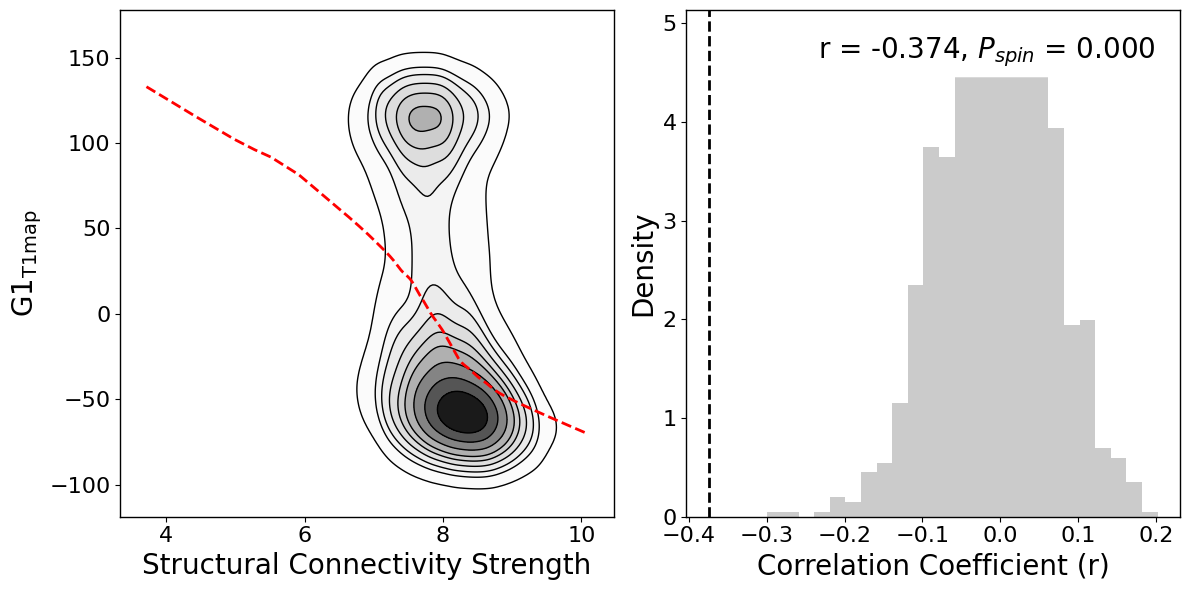

In [14]:
plot_ctx_spin_permutation(ctx='structural', qMRI='T1map')

### Structural connectivity strength ~ MTsat G1

/tmp/ipykernel_74351/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/host/verges/tank/data/youngeun/venv_new/lib/python3.10/site-packages/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')


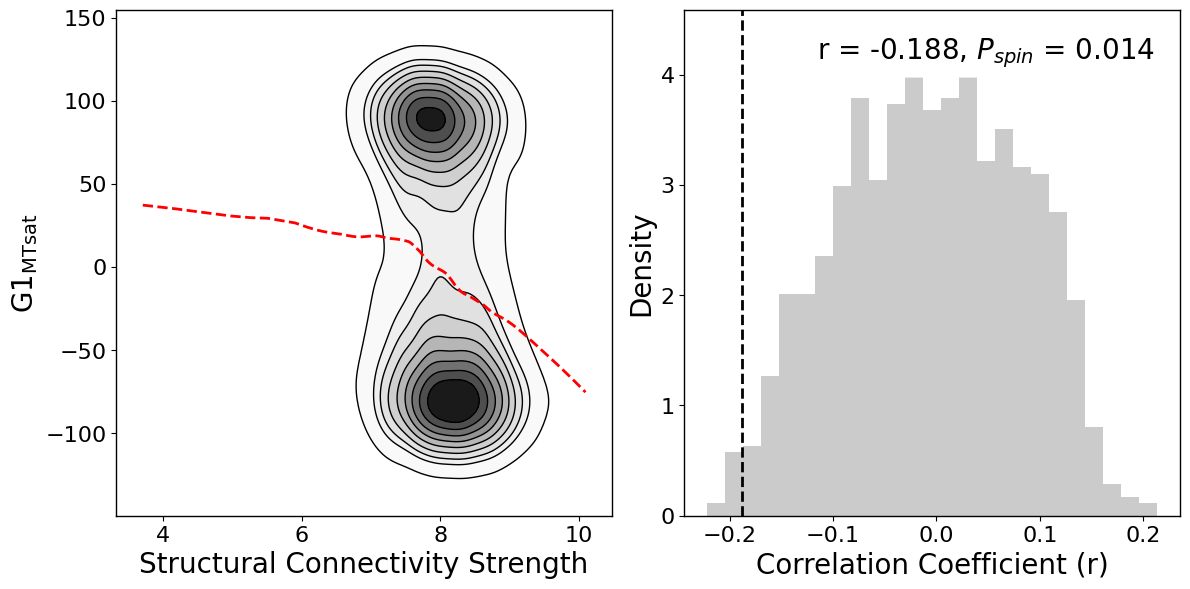

In [15]:
plot_ctx_spin_permutation(ctx='structural', qMRI='MTSAT')